In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import os.path
import pickle
from scipy.stats import norm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaOptim import SepiaOptim

In [35]:
import os
datadir = os.getcwd()+"/data/data_ball_drop_2/"
# experimental data
with open(datadir+'fieldDat15x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
x_obs = x

y_obs = [np.array(field_data[0:3,4]),np.array(field_data[3:6,4]),\
         np.array(field_data[6:12,4]),np.array(field_data[12:,4])]
h_obs = [np.array(field_data[0:3,3]),np.array(field_data[3:6,3]),\
         np.array(field_data[6:12,3]),np.array(field_data[12:,3])]# observed heights

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)

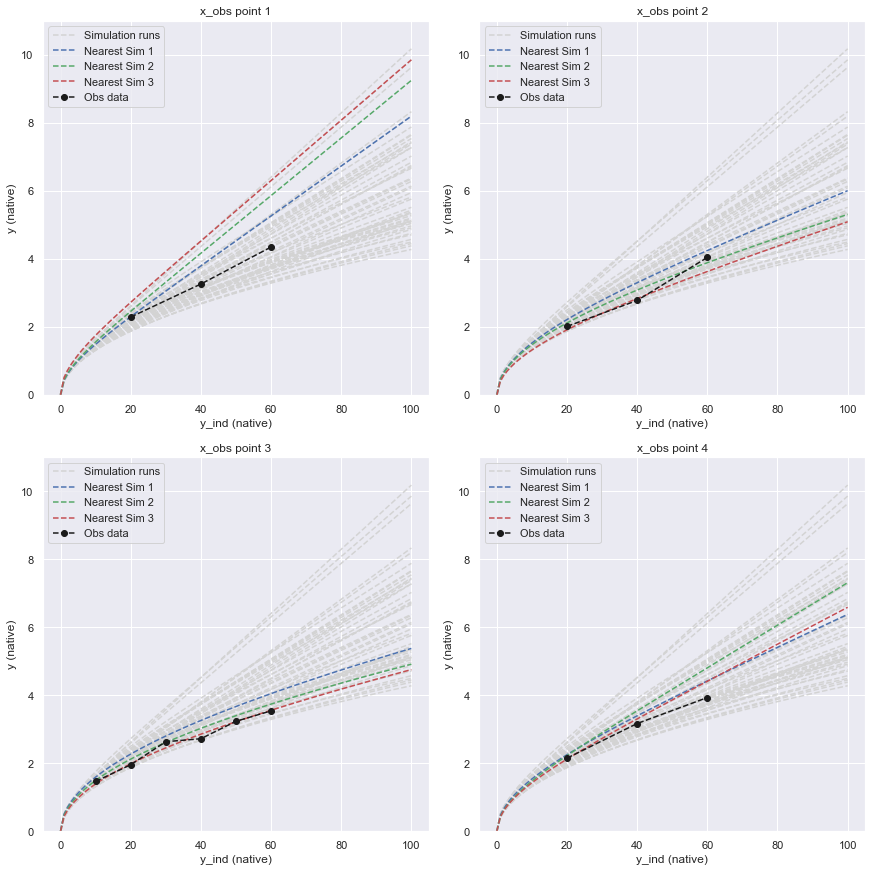

In [36]:
data_figure = data.plot_data(x_min = -5, x_max = 105, y_min = 0, y_max = 11)

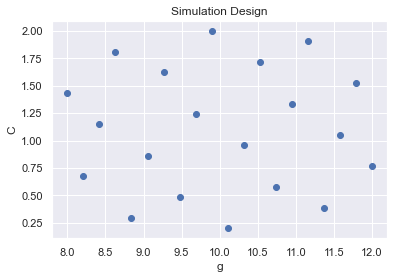

In [37]:
fig,ax = plt.subplots()
ax.scatter(t_sim[0:20,1],t_sim[0:20,0])
ax.set_xlabel("g");ax.set_ylabel("C"),ax.set_title("Simulation Design")
plt.show()

In [38]:
data.transform_xt()
data.standardize_y()

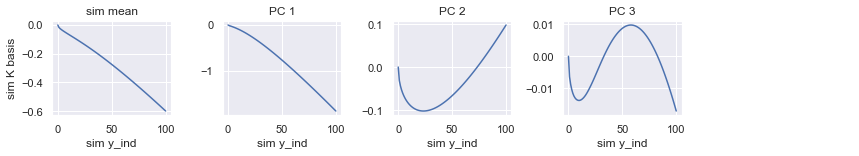

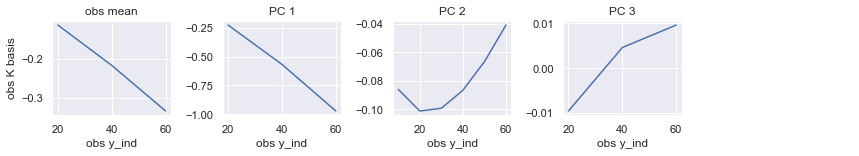

In [39]:
data.create_K_basis(3)
fig_sim, fig_obs = data.plot_K_basis()

In [40]:
data.create_D_basis('linear')
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension ragged
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



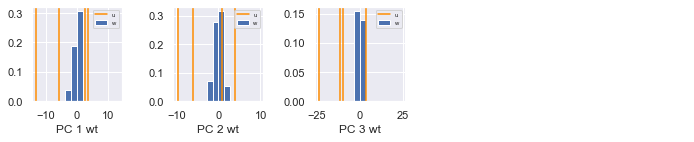

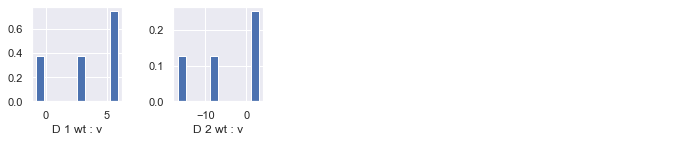

In [41]:
fig_uw, fig_v = data.plot_K_weights()

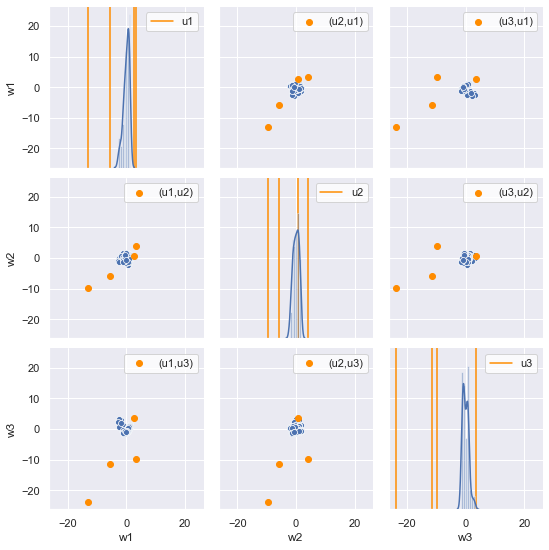

In [42]:
uw_figure = data.plot_u_w_pairs()

## MCMC with option for parameter optimization

In [43]:
model = SepiaModel(data)

override= 0
optim = 1
cachefile_name='pkls/ball_drop_2_raggedmodel'

if os.path.isfile(cachefile_name+'.pkl') and override==0:
    model.restore_model_info(cachefile_name)
else:
    if optim:
        optimizer = SepiaOptim(model)
        x_opt, f_opt, f_hist, it, fnc_calls, p_native = optimizer.particle_swarm(w_max=.9,w_min=.4,c1=.5,c2=.3,\
                             maxiter=1000,swarmsize=100,obj_tol=1e-8,step_tol=1e-8,
                            log_transform=['betaU','betaV','lamUz','lamVz','lamOs','lamWOs','lamWs'],verbose=True)
        optimizer.set_model_params(p_native)
        model.tune_step_sizes(50, 20, update_vals=False)
    else:
        model.tune_step_sizes(50,20,update_vals=True)
    model.do_mcmc(5000)
    model.save_model_info(cachefile_name)

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.


In [44]:
samples_dict = model.get_samples()
theta_names = ['C','g']
p_stats = SepiaPlot.param_stats(samples_dict,theta_names=theta_names,q1=.05,q2=.95,digits=4)
print(np.round(p_stats,4))

                      mean         sd  0.05 quantile  0.95 quantile
C                   0.2055     0.0425         0.1364         0.2747
g                   0.4940     0.0815         0.3700         0.6251
betaV_1             1.7110     2.9676         0.0033         7.5769
betaV_2             1.4626     2.5362         0.0023         7.1865
betaU_1             0.2504     0.1359         0.0928         0.5124
betaU_2             0.8579     0.3409         0.4488         1.4994
betaU_3             0.2102     0.0655         0.1300         0.3394
betaU_4             0.0731     0.0218         0.0459         0.1140
betaU_5             0.0540     0.0278         0.0216         0.1082
betaU_6             0.1125     0.0538         0.0503         0.2129
betaU_7             0.8856     0.1735         0.6339         1.1980
betaU_8             0.3499     0.0781         0.2385         0.4938
betaU_9             0.6709     0.4029         0.2743         1.3301
betaU_10            0.9308     0.5787         0.

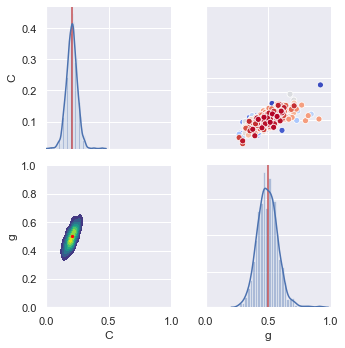

In [45]:
theta_post_fig = SepiaPlot.theta_pairs(samples_dict,theta_names,theta_ref=[[0.2075],[0.5003]],save='plots/theta_post.png')

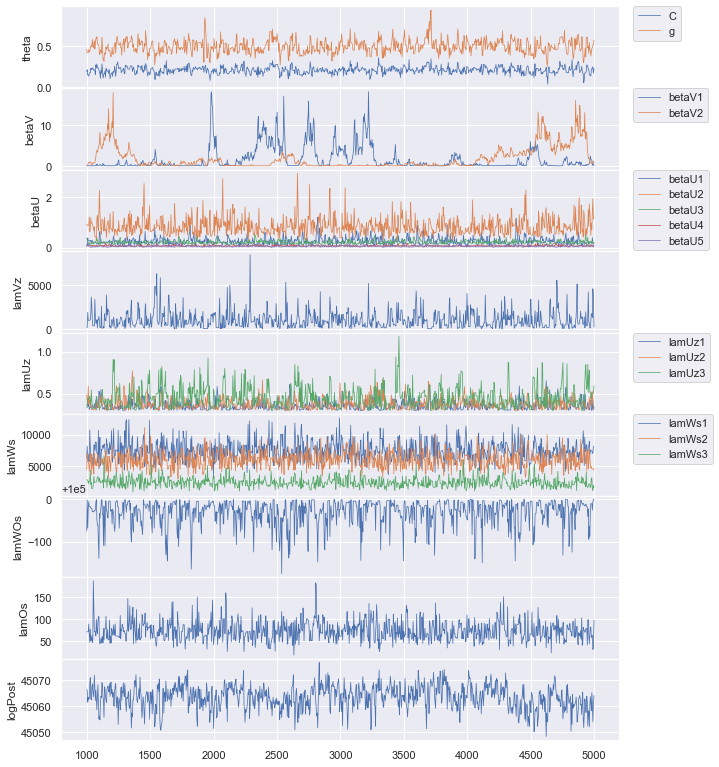

In [46]:
mcmc_trace_fig = SepiaPlot.mcmc_trace(samples_dict,theta_names,start=1000,n_to_plot=1000,max_print=5,\
                                     save='plots/mcmc_trace.png')

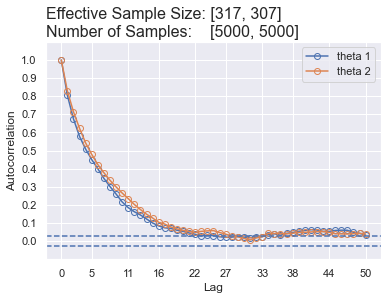

In [47]:
acf = SepiaPlot.plot_acf(model,nlags=50,nburn=0,save='plots/acf.png')

In [48]:
from sepia.SepiaPredict import SepiaFullPrediction
pred_samples=model.get_samples(nburn=1000,effectivesamples=True)
pred=SepiaFullPrediction(x_pred=data.obs_data.x, samples=pred_samples, model=model)

Max effective sample size over thetas: 262
Total samples: 4000


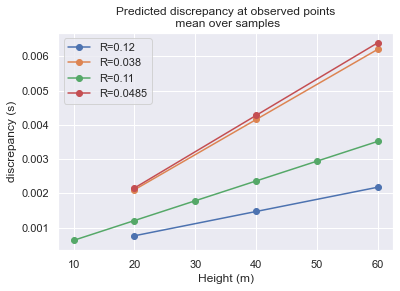

In [89]:
predd=[]
for i in range(4):
    predd.append(pred.get_discrepancy(as_obs=True,obs_ref=i))
fig, ax = plt.subplots()
for i in range(4):
    ax.plot(model.data.obs_data.y_ind[i],np.mean(predd[i],0).T,marker='o',label='R={}'.format(x_obs[i,0]))  
ax.set_xlabel('Height (m)')
ax.set_ylabel('discrepancy (s)')
ax.set_title('Predicted discrepancy at observed points\n mean over samples')
plt.legend()
plt.show()

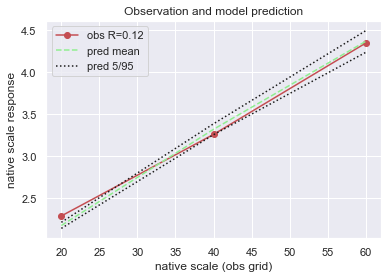

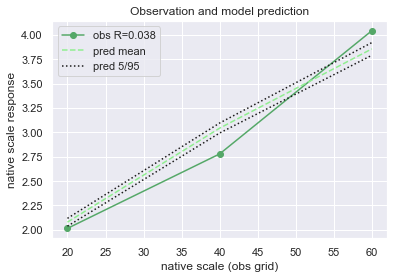

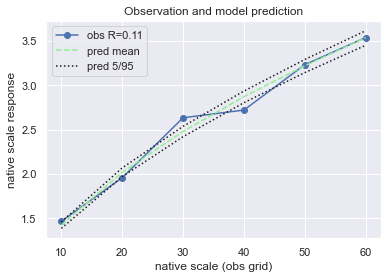

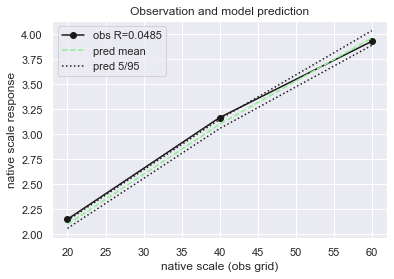

In [90]:
colors = ('r','g','b','k')
for R_idx in range(4):
    plt.figure()
    predyobs=pred.get_yobs(as_obs=True, obs_ref=R_idx)
    plt.plot(model.data.obs_data.y_ind[R_idx],model.data.obs_data.y[R_idx],marker='o',c=colors[R_idx])
    plt.plot(model.data.obs_data.y_ind[R_idx],np.mean(predyobs,0).T,'--',c='lightgreen')
    plt.plot(model.data.obs_data.y_ind[R_idx],np.quantile(predyobs,[0.05, 0.95],axis=0).T,'k:')
    plt.xlabel('native scale (obs grid)')
    plt.ylabel('native scale response')
    plt.title('Observation and model prediction')
    plt.legend(['obs R={}'.format(x_obs[R_idx,0]),'pred mean','pred 5/95'])
    plt.show()